In [6]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [7]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [8]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [9]:
# sub number
sub_num = 4

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 6s 58ms/step - loss: 0.5692 - accuracy: 0.7535 - val_loss: 0.5758 - val_accuracy: 0.7367
Epoch 2/200
99/99 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.7544
Epoch 00002: val_loss improved from inf to 0.56031, saving model to best_model_5.h5
99/99 [==============================] - 6s 58ms/step - loss: 0.5566 - accuracy: 0.7544 - val_loss: 0.5603 - val_accuracy: 0.7367
Epoch 3/200
99/99 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.7544
Epoch 00003: val_loss improved from 0.56031 to 0.55959, saving model to best_model_5.h5
99/99 [==============================] - 6s 57ms/step - loss: 0.5530 - accuracy: 0.7544 - val_loss: 0.5596 - val_accuracy: 0.7367
Epoch 4/200
99/99 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.7544
Epoch 00004: val_loss did not improve from 0.55959
99/99 [==============================] - 6s 56ms/step - loss: 0.5523 - accuracy: 0.7544 - 

Epoch 30/200
99/99 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.8970
Epoch 00030: val_loss improved from 0.32316 to 0.31247, saving model to best_model_5.h5
99/99 [==============================] - 6s 57ms/step - loss: 0.2479 - accuracy: 0.8970 - val_loss: 0.3125 - val_accuracy: 0.8479
Epoch 31/200
99/99 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.8929
Epoch 00031: val_loss improved from 0.31247 to 0.31157, saving model to best_model_5.h5
99/99 [==============================] - 6s 57ms/step - loss: 0.2426 - accuracy: 0.8929 - val_loss: 0.3116 - val_accuracy: 0.8517
Epoch 32/200
98/99 [============================>.] - ETA: 0s - loss: 0.2388 - accuracy: 0.8999
Epoch 00032: val_loss did not improve from 0.31157
99/99 [==============================] - 6s 57ms/step - loss: 0.2406 - accuracy: 0.8989 - val_loss: 0.3171 - val_accuracy: 0.8460
Epoch 33/200
99/99 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.8999

99/99 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9087
Epoch 00059: val_loss did not improve from 0.24314
99/99 [==============================] - 5s 55ms/step - loss: 0.2144 - accuracy: 0.9087 - val_loss: 0.3598 - val_accuracy: 0.8451
Epoch 60/200
99/99 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9157
Epoch 00060: val_loss did not improve from 0.24314
99/99 [==============================] - 5s 55ms/step - loss: 0.2074 - accuracy: 0.9157 - val_loss: 0.3551 - val_accuracy: 0.8498
Epoch 61/200
99/99 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9122
Epoch 00061: val_loss did not improve from 0.24314
99/99 [==============================] - 5s 55ms/step - loss: 0.2056 - accuracy: 0.9122 - val_loss: 0.3524 - val_accuracy: 0.8413
Epoch 62/200
99/99 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9116
Epoch 00062: val_loss did not improve from 0.24314
99/99 [============================

Epoch 89/200
99/99 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9176
Epoch 00089: val_loss did not improve from 0.24314
99/99 [==============================] - 6s 56ms/step - loss: 0.1931 - accuracy: 0.9176 - val_loss: 0.2494 - val_accuracy: 0.8945
Epoch 90/200
99/99 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9170
Epoch 00090: val_loss did not improve from 0.24314
99/99 [==============================] - 5s 54ms/step - loss: 0.1959 - accuracy: 0.9170 - val_loss: 0.2741 - val_accuracy: 0.8869
Epoch 91/200
99/99 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9227
Epoch 00091: val_loss did not improve from 0.24314
99/99 [==============================] - 6s 56ms/step - loss: 0.1847 - accuracy: 0.9227 - val_loss: 0.4297 - val_accuracy: 0.8203
Epoch 92/200
99/99 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9173
Epoch 00092: val_loss did not improve from 0.24314
99/99 [===============

Epoch 119/200
99/99 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9240
Epoch 00119: val_loss improved from 0.24314 to 0.24310, saving model to best_model_5.h5
99/99 [==============================] - 6s 56ms/step - loss: 0.1836 - accuracy: 0.9240 - val_loss: 0.2431 - val_accuracy: 0.9002
Epoch 120/200
99/99 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9246
Epoch 00120: val_loss did not improve from 0.24310
99/99 [==============================] - 6s 57ms/step - loss: 0.1855 - accuracy: 0.9246 - val_loss: 0.2873 - val_accuracy: 0.8755
Epoch 121/200
99/99 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9221
Epoch 00121: val_loss did not improve from 0.24310
99/99 [==============================] - 5s 55ms/step - loss: 0.1832 - accuracy: 0.9221 - val_loss: 0.2835 - val_accuracy: 0.8821
Epoch 122/200
99/99 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9347
Epoch 00122: val_loss did not im

98/99 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9311
Epoch 00148: val_loss did not improve from 0.23851
99/99 [==============================] - 6s 56ms/step - loss: 0.1632 - accuracy: 0.9316 - val_loss: 0.3301 - val_accuracy: 0.8603
Epoch 149/200
98/99 [============================>.] - ETA: 0s - loss: 0.1713 - accuracy: 0.9292
Epoch 00149: val_loss did not improve from 0.23851
99/99 [==============================] - 6s 56ms/step - loss: 0.1712 - accuracy: 0.9293 - val_loss: 0.2853 - val_accuracy: 0.8821
Epoch 150/200
99/99 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9274
Epoch 00150: val_loss did not improve from 0.23851
99/99 [==============================] - 6s 57ms/step - loss: 0.1655 - accuracy: 0.9274 - val_loss: 0.2874 - val_accuracy: 0.8840
Epoch 151/200
99/99 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9312
Epoch 00151: val_loss did not improve from 0.23851
99/99 [=========================

Epoch 178/200
99/99 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9211
Epoch 00178: val_loss did not improve from 0.23851
99/99 [==============================] - 6s 56ms/step - loss: 0.1883 - accuracy: 0.9211 - val_loss: 0.3137 - val_accuracy: 0.8745
Epoch 179/200
99/99 [==============================] - ETA: 0s - loss: 0.1715 - accuracy: 0.9312
Epoch 00179: val_loss did not improve from 0.23851
99/99 [==============================] - 6s 56ms/step - loss: 0.1715 - accuracy: 0.9312 - val_loss: 0.2932 - val_accuracy: 0.8802
Epoch 180/200
99/99 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9363
Epoch 00180: val_loss did not improve from 0.23851
99/99 [==============================] - 6s 56ms/step - loss: 0.1613 - accuracy: 0.9363 - val_loss: 0.2959 - val_accuracy: 0.8850
Epoch 181/200
99/99 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9284
Epoch 00181: val_loss did not improve from 0.23851
99/99 [===========

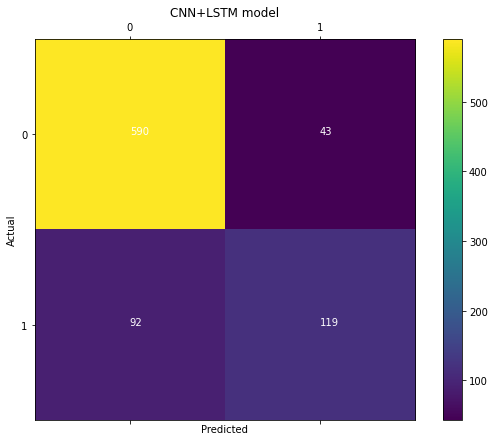

val_loss: 0.23851278424263
test_loss: 0.38340434432029724
test_acc: 0.8400474190711975
precision: 0.7345679012345679
recall: 0.5639810426540285
specificity 0.9320695102685624
sensitivity :  0.5639810426540285
far 0.0679304897314376
frr 0.43601895734597157


In [10]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 4, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
# conv_2 = tf.keras.layers.Conv1D(filters = 179, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
# max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
# conv_3 = tf.keras.layers.Conv1D(filters = 37, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
# max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    
D_out_1 = tf.keras.layers.Dropout(0.27506014989460326)(max_1)
    
lstm_1 = tf.keras.layers.LSTM(39)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(11, activation = 'relu')(lstm_1)
# dense_2 = tf.keras.layers.Dense(42, activation = 'relu')(dense_1)
dense_3 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_1)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_3)

# Adam
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.00287010197769885), metrics = ['accuracy'])
# SGD
# model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.0009343048185018842, momentum=0.9379592661454418), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])

# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)